In [23]:
import function as game
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import doctest

In [25]:
#check if the bid is valid
def valid_bid(bids):
    """
    Check if the bid sequence is valid: at least one of quantity or face_value
    increases in every step.

    :param bids: List of bids, where each bid is [quantity, face_value].
    :return: True if all bids are valid, False otherwise.
    >>> bids = [[4, 1], [4, 2], [10, 5], [14, 5], [16, 4], [18, 4], [19, 4]]
    >>> valid_bid(bids)
    True
    >>> bids = [[4, 1], [4, 2], [10, 5], [9, 5], [16, 4], [18, 4], [19, 4]]
    >>> valid_bid(bids)
    False
    """
    is_increasing = True  
    for i in range(1, len(bids)):
        prev_quantity, prev_face_value = bids[i - 1]
        curr_quantity, curr_face_value = bids[i]
        if not (curr_quantity > prev_quantity or curr_face_value > prev_face_value):
            is_increasing = False
            break
    return is_increasing
doctest.testmod()

TestResults(failed=0, attempted=4)

In [27]:
class Validation_varaibales:
     # set the validation varaiables
    def __init__(self,num_players,num_dices,times):
        self.num_players = num_players
        self.num_dices = num_dices
        self.times = times
        self.results = {}
        self.first_players = {}
        for i in range(num_players):
            self.results[f"player{i}"] = 0
            self.first_players[f'player {i}'] = 0
        self.original = {key: 0 for key in range(1, 7)}
        self.liar_player = {key :0 for key in range(num_players)}
        quantity = list(range(1, (num_players * num_dices) + 1)) 
        face_value = list(range(1, 7))
        data = [(q, f, 0, 0, 0) for q in quantity for f in face_value]
        self.liar_occur_bid = pd.DataFrame(data,columns = ['quantity','face_value','times','valid_times','invalid_times'])
        self.liar_result = {"valid":0, "invalid" :0}
        

    def update(self,winner, first_player, bid_record, liar_record, bid_times, original_dices):
        #check if the bid is valid 
        for bid in bid_record:
            bids = []
            for player, action in bid.items():
                if action == 'liar':
                    if valid_bid(bids):
                        pass 
                    else:
                        print("There are invalid bid exists")
                        break
                else:
                    bids.append(action)
    
        #record the winner and the first player distribution
        self.results[f"player{winner}"] += 1
        self.first_players[f"player {first_player}"] += 1
        
        #record the original dice distribution
        for key, values in original_dices.items():
            self.original[key] += values
    
        #record the liar call results
        for i in range(len(liar_record)):
            bid_times,current_player,challenge_bid,result,active_players = liar_record[i]
            if result == "valid":
                self.liar_result['valid']  += 1 
            else:
                self.liar_result['invalid'] += 1
            self.liar_player[current_player] += 1
            quantity, face_value = challenge_bid
            index = self.liar_occur_bid[(self.liar_occur_bid['quantity'] == quantity) & (self.liar_occur_bid['face_value'] == face_value)].index
            self.liar_occur_bid.loc[index,'times'] += 1
            if result == "valid":
                self.liar_occur_bid.loc[index,'valid_times'] += 1 
            else:
                self.liar_occur_bid.loc[index,'invalid_times'] += 1

    
    def check_original_dices(self):
        #check if the original dices are random
        df = pd.DataFrame(list(self.original.items()), columns=["Face_value", "Occurrence"])
        df['Occurrence rate'] = df['Occurrence'] / (self.times * self.num_players * self.num_dices)
        df["Occurrence rate"] = df["Occurrence rate"].apply(lambda x: f"{x:.2%}") 
        print(df)


    def check_win_rate(self):
        # check if everyone's win rate is equal 
        win_rate_df = pd.DataFrame(list(self.results.items()), columns=["Player", "Wins"])
        win_rate_df['Win Rate'] = win_rate_df['Wins'] / self.times
        win_rate_df["Win Rate"] = win_rate_df["Win Rate"].apply(lambda x: f"{x:.2%}") 
        print(win_rate_df)


    def check_first_player(self):
        #check if the first player is random
        start_rate_df = pd.DataFrame(list(self.first_players.items()), columns=["Player", "Start times"])
        start_rate_df['Start rate'] = start_rate_df['Start times'] / self.times
        start_rate_df["Start rate"] = start_rate_df["Start rate"].apply(lambda x: f"{x:.2%}") 
        print(start_rate_df)

    def check_liar_call(self):
        #check if the liar call is random 
        self.liar_occur_bid = self.liar_occur_bid.sort_values(by='times', ascending=False)
        print(self.liar_occur_bid)
        #draw the heatmap of challenge_bid 
        pivot_table = self.liar_occur_bid.pivot(index='face_value', columns='quantity', values='times')
        sns.heatmap(pivot_table, annot=False, fmt="d", cmap="coolwarm", cbar=True)
        plt.title("Heatmap of Quantity vs Face Value")
        plt.xlabel("Quantity")
        plt.ylabel("Face Value")
        plt.show()

    def check_liar_valid_rate(self):
        #check if with the quantity rasies, the valid rate increases,
        #need to exclude the maxmum quantity matching the max_dices
        grouped_liar = self.liar_occur_bid.groupby('quantity').agg({'times':'sum', 'valid_times':'sum', 'invalid_times':'sum'})
        grouped_liar['valid_rate'] = grouped_liar['valid_times'] / grouped_liar['times']
        grouped_liar
        plt.figure(figsize=(8, 6))
        plt.plot(grouped_liar.index, grouped_liar['valid_rate'], marker='o', label='Valid Rate')
        plt.title("Valid Rate across Quantity")
        plt.xlabel("Quantity")
        plt.ylabel("Valid Rate")
        plt.ylim(0, 1)  # Valid rate is a ratio (0 to 1)
        plt.grid(True)
        plt.legend()
        plt.show()

### Validation for the random stragegies

In [29]:
# simulat the game with 5 players and each player has 5 dices(everyone uses random strategies)
num_players = 5
num_dice = 5
times = 1000  
validation_test = Validation_varaibales(num_players,num_dice,times)
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4181          16.72%
1           2        4087          16.35%
2           3        4152          16.61%
3           4        4267          17.07%
4           5        4168          16.67%
5           6        4145          16.58%



win rate distribution
    Player  Wins Win Rate
0  player0   186   18.60%
1  player1   203   20.30%
2  player2   191   19.10%
3  player3   224   22.40%
4  player4   196   19.60%



first player distribution
     Player  Start times Start rate
0  player 0          186     18.60%
1  player 1          216     21.60%
2  player 2          195     19.50%
3  player 3          197     19.70%
4  player 4          206     20.60%



challenge bid distribution
     quantity  face_value  times  valid_times  invalid_times
59         10           6    623          620              3
89         15           6    552          552              0
119        20           6    478          478    

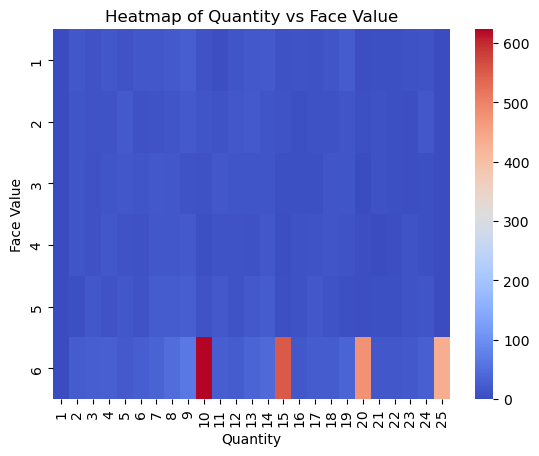




liar valid rate


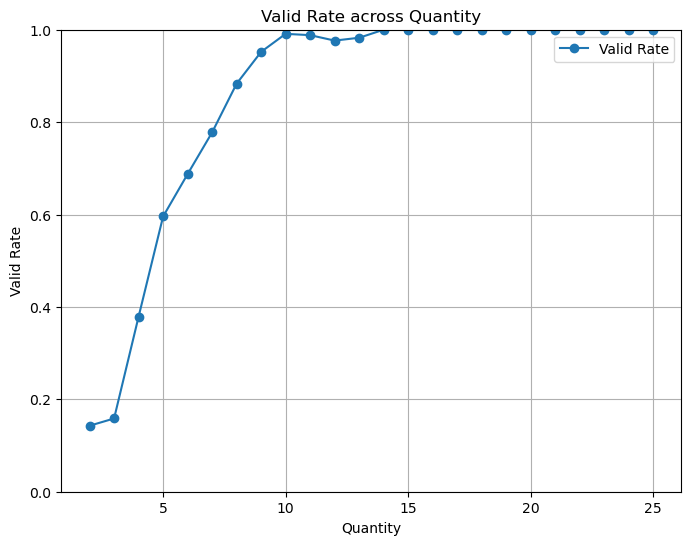

In [31]:
#check 
print("dice distribution")
validation_test.check_original_dices()
print("\n" * 2)
print("win rate distribution")
validation_test.check_win_rate()
print("\n" * 2)
print("first player distribution")
validation_test.check_first_player()
print("\n" * 2)
print("challenge bid distribution")
validation_test.check_liar_call()
print("\n" * 2)
print("liar valid rate")
validation_test.check_liar_valid_rate()

### Test for the first_caller hypothesis:

In [33]:
# Simulat the game with 5 players and each player has 5 dice (everyone uses random strategies,but the first player always bid first)
num_players = 5
num_dice = 5
times = 1000  
validation_test = Validation_varaibales(num_players,num_dice,times)
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice,starter = 0)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

dice distribution
   Face_value  Occurrence Occurrence rate
0           1        4180          16.72%
1           2        4211          16.84%
2           3        4024          16.10%
3           4        4173          16.69%
4           5        4184          16.74%
5           6        4228          16.91%



win rate distribution
    Player  Wins Win Rate
0  player0   197   19.70%
1  player1   155   15.50%
2  player2   205   20.50%
3  player3   200   20.00%
4  player4   243   24.30%



first player distribution
     Player  Start times Start rate
0  player 0         1000    100.00%
1  player 1            0      0.00%
2  player 2            0      0.00%
3  player 3            0      0.00%
4  player 4            0      0.00%



challenge bid distribution
     quantity  face_value  times  valid_times  invalid_times
59         10           6    634          631              3
89         15           6    530          530              0
119        20           6    481          481    

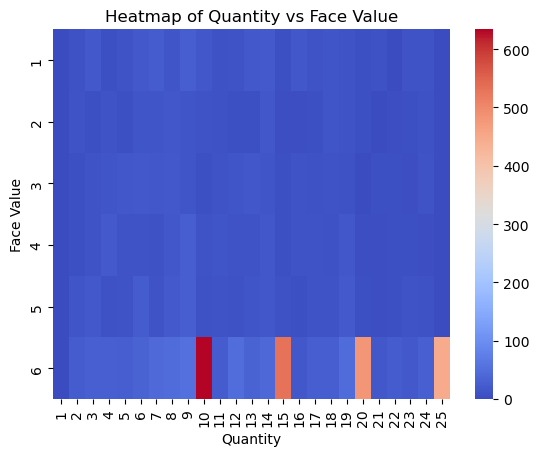




liar valid rate


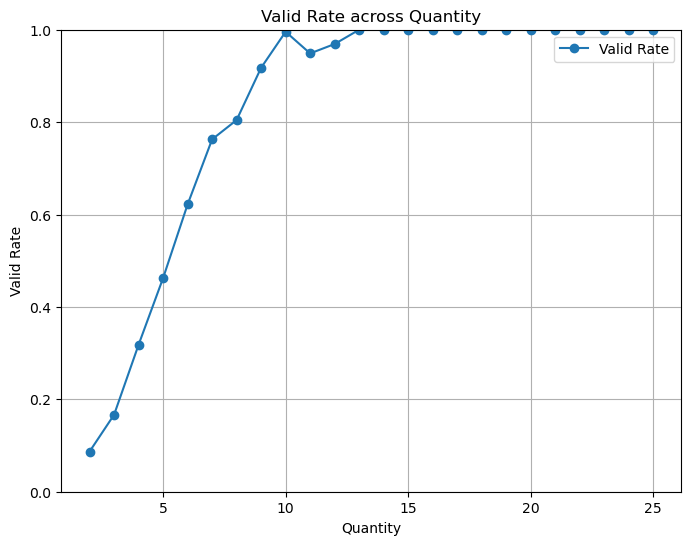

In [35]:
#check 
print("dice distribution")
validation_test.check_original_dices()
print("\n" * 2)
print("win rate distribution")
validation_test.check_win_rate()
print("\n" * 2)
print("first player distribution")
validation_test.check_first_player()
print("\n" * 2)
print("challenge bid distribution")
validation_test.check_liar_call()
print("\n" * 2)
print("liar valid rate")
validation_test.check_liar_valid_rate()

### Test hypothesis for special rule

In [39]:
# Simulat the game with 5 players and each player has 5 dice (everyone uses random strategies,but plays under special rule)
num_players = 5
num_dice = 5
times = 1000  
validation_test = Validation_varaibales(num_players,num_dice,times)
for _ in range(times):
    winner, first_player, bid_record, liar_record, bid_times,original_dices = game.simulate_game(num_players, num_dice,starter = -1, special_rule = True)
    validation_test.update(winner, first_player, bid_record, liar_record, bid_times, original_dices)

TypeError: simulate_game() got an unexpected keyword argument 'special_rule'